# Homework 08
### IANNWTF 20/21
group 08: Johanna Linkemeyer, Marisa Wodrich





In this homework we implemented a **generative adversarial network** for the Fashion MNIST dataset.


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras import Model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K

## **Data set**
We worked with the Fashion MNIST data set. 
* 60000 train images
* 10000 test images
* size 28 x 28 x 1 
* 10 different categories

For this task we mainly used the train images. We also did not use the labels, are they are not needed for training neither the discriminator nor the Generator of our implemented GAN.
The test_images are not entirely used, but only a small random subpart of them will be used in each testing step.

In [2]:
# Load fashion MNIST dataset 
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


**Taking a look at the data**

Print the shape and value range and print some examples to understand the data set.

In [3]:
# Print info on images
print('Train images - Shape: %s - Value range: %s' % (train_images.shape, [np.min(train_images), np.max(train_images)]))
print('Test images - Shape: %s - Value range: %s' % (test_images.shape, [np.min(test_images), np.max(test_images)]))

Train images - Shape: (60000, 28, 28) - Value range: [0, 255]
Test images - Shape: (10000, 28, 28) - Value range: [0, 255]


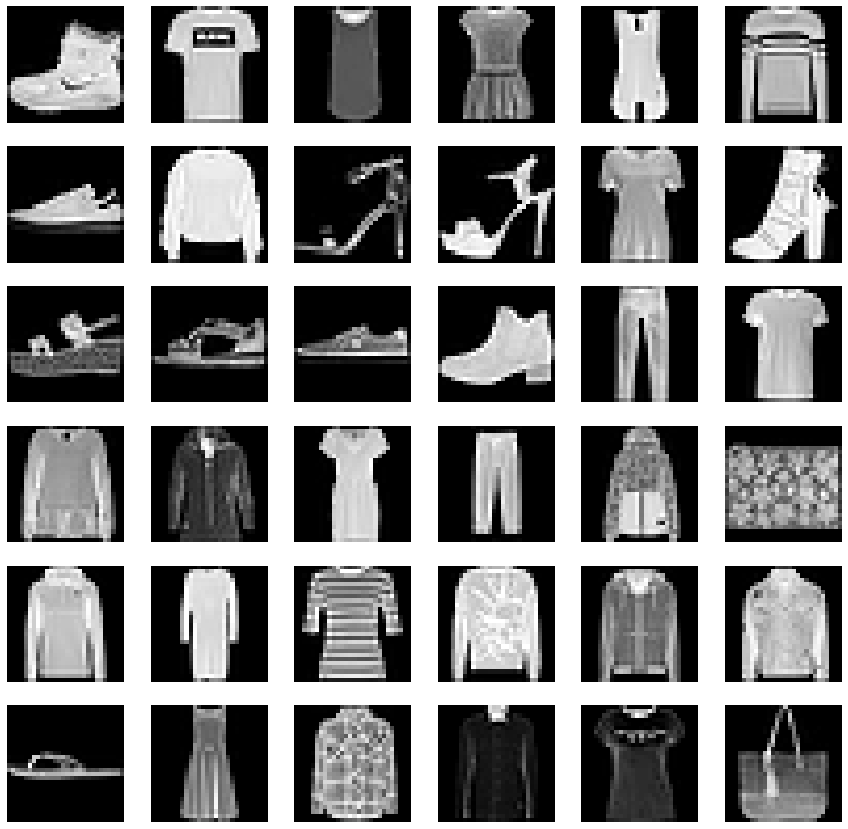

In [4]:
# print some example images

_, ax = plt.subplots(6, 6, figsize=(15,15))
plt.gray() # plot in grayscale

for i, img in enumerate(train_images[:6*6]):
  x, y = int(i / 6), i % 6
  ax[x,y].imshow(img) ; ax[x,y].axis('off')

plt.show()

**Preprocessing steps**

In [5]:
# parameters for our data sets and our models
BATCH_SIZE = 64
LATENTSPACE_SIZE = 100
TEST_SIZE = 10           # how many images are generated at each testing step

In [6]:
# Preprocess training data
train_images = train_images.astype(np.float32)
train_images_prep = tf.expand_dims(train_images, -1)
train_images_prep = tf.data.Dataset.from_tensor_slices(train_images_prep)

# Normalize training images (range [-1,1])
train_images_prep = train_images_prep.map(lambda x: (x/255)*2 - 1)

# Batching and shuffling
train_imgs = train_images_prep.shuffle(buffer_size=10000)
train_imgs = train_imgs.batch(BATCH_SIZE, drop_remainder=True)

In [7]:
# Print info on training set after passing all images through 
# the preprocessing pipeline
print(train_imgs)

<BatchDataset shapes: (64, 28, 28, 1), types: tf.float32>


**Test dataset**

In [8]:
# create test data set

def make_test_data():
  """
  For each call creates a random batch from the test dataset.
  """
  idx = np.random.randint(0,10000-TEST_SIZE)

  # Preprocess a small amount of test images 
  test_images_prep = test_images[idx:idx+TEST_SIZE]
  test_images_prep = tf.expand_dims(test_images, -1)
  test_images_prep = tf.data.Dataset.from_tensor_slices(test_images_prep)

  # Normalize test images (range [-1,1])
  test_images_prep = test_images_prep.map(lambda x: (x/255)*2 - 1)

  # Batching and shuffling (we will use one random batch each time during testing)
  test_imgs = test_images_prep.shuffle(buffer_size=10000)
  test_imgs = test_imgs.batch(TEST_SIZE, drop_remainder=True)

  return test_imgs

In [9]:
# Test the functionality of our test dataset creator
print(make_test_data())

<BatchDataset shapes: (10, 28, 28, 1), types: tf.float32>


**Test vectors**

We create some random latent vectors before training. At each test step, we feed them into the generator and plot the resulting images to evaluate training.

In [10]:
test_vectors = tf.random.normal([TEST_SIZE, LATENTSPACE_SIZE])

## **Model**

We implemented a generative adversarial network. We therefore have: 

* a **Discriminator**: takes in images, returns probabilities in the range from 0-1 that images were fake (0) / real (1)
* a **Generator**: takes in a random vector from the latent space and produces generated image

Both networks try to optimize their task and therefore kind of work against each other.

For the design of the model we used the following sources: 
* https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
* https://www.tensorflow.org/tutorials/generative/dcgan

In [11]:
# activation functions
SIGMOID = tf.nn.sigmoid
TANH = tf.nn.tanh

#### **Discriminator**

In [12]:
class Discriminator(Model):

  def __init__(self, wasserstein=False):
    """
    A Discriminator consists out of several convolutional layers followed by 
    leaky relu and a dropout layer. If initialized as a Wasserstein 
    discriminator by passing the flag wasserstein=True, weight clipping to the 
    range -0.01 to 0.01 is performed.
    In the end, the discriminator will return a value representing whether an 
    image was fake or real.
    wasserstein:      (bool) whether or not the discriminator should be 
                      instantiated as Wasserstein discriminator or not (default)
    """
    super(Discriminator, self).__init__()

    if wasserstein:
      # Apply weight clipping (set kernel + bias constraint with min_max_norm)
      self.conv_1 = layers.Conv2D(filters=16, 
                                  kernel_size=5, 
                                  strides=2, 
                                  input_shape=[28,28,1], 
                                  padding='same', 
                                  activation=None, 
                                  kernel_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01),
                                  bias_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01))
    else:
      self.conv_1 = layers.Conv2D(filters=16, 
                                  kernel_size=5, 
                                  strides=2, 
                                  input_shape=[28,28,1], 
                                  padding='same', 
                                  activation=None)
    self.leaky_relu_1 = layers.LeakyReLU()
    self.dropout_1 = layers.Dropout(0.3)

    if wasserstein:
      self.conv_2 = layers.Conv2D(filters=32, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  activation=None,
                                  kernel_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01),
                                  bias_constraint=tf.keras.constraints.min_max_norm(min_value=-0.01, max_value=0.01))
    else:
      self.conv_2 = layers.Conv2D(filters=32, 
                                  kernel_size=5, 
                                  strides=2, 
                                  padding='same', 
                                  activation=None)
    self.leaky_relu_2 = layers.LeakyReLU()
    self.dropout_2 = layers.Dropout(0.3)

    self.flatten = layers.Flatten()

    if wasserstein:
      self.out = layers.Dense(1, activation=None) # linear activation for Wasserstein
    else:
      self.out = layers.Dense(1, SIGMOID)


  @tf.function
  def call(self, x, is_training=True):
    """
    Discriminator call function
    x:            network input
    is_training:  training flag (true for train steps (default), false for test 
                  steps)
    """

    x = self.conv_1(x)
    x = self.leaky_relu_1(x)
    x = self.dropout_1(x, is_training)

    x = self.conv_2(x)
    x = self.leaky_relu_2(x)
    x = self.dropout_2(x, is_training)
    
    x = self.flatten(x)
    x = self.out(x)
    
    return x

**Test discriminator functionality**

In [13]:
# Create one batch of one black image of size 28x28x1
inp = tf.zeros((1,28,28,1))

# Initialize and test discriminator
discriminator_test = Discriminator()
result = discriminator_test(inp)

# Print information on output and model summary
print(result.shape)
discriminator_test.summary()

(1, 1)
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  416       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  12832     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple         

**Test Wasserstein discriminator functionality**

In [14]:
# Test on the same input as above, initialize discriminator as 
# Wasserstein version
w_discriminator_test = Discriminator(wasserstein=True)
w_result = w_discriminator_test(inp)

# Print information on output and model summary
print(w_result.shape)
w_discriminator_test.summary()

(1, 1)
Model: "discriminator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  416       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_2 (Dropout)          multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  12832     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
flatten_1 (Flatten)          multiple       

#### **Generator**

In [44]:
class Generator(Model):

  def __init__(self):
    """
    A Generator takes in a one-dimensional vector. 
    It reshapes it and applies several transposed convolutions to 
    return an image in the end.
    """
    super(Generator, self).__init__()

    self.dense = layers.Dense(7*7*128, input_shape=(LATENTSPACE_SIZE,), use_bias=False, activation=None)
    self.leaky_relu_0 = layers.LeakyReLU()
    self.reshape = layers.Reshape((7,7,128))

    self.convT_1 = layers.Conv2DTranspose(filters=64, kernel_size=4, strides=1, padding='same', activation=None, use_bias=False)
    self.batch_norm_1 = layers.BatchNormalization()
    self.leaky_relu_1 = layers.LeakyReLU()

    self.convT_2 = layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, padding='same', activation=None, use_bias=False)
    self.batch_norm_2 = layers.BatchNormalization()
    self.leaky_relu_2 = layers.LeakyReLU()

    self.convT_3 = layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, padding='same', activation=TANH, use_bias=False)


  @tf.function
  def call(self, x, is_training=True):
    """
    Generator call function
    x:            network input
    is_training:  training flag (true for train steps (default), false for test 
                  steps)
    """

    x = self.dense(x)
    x = self.leaky_relu_0(x)
    x = self.reshape(x)

    x = self.convT_1(x)
    x = self.batch_norm_1(x, is_training)
    x = self.leaky_relu_1(x)

    x = self.convT_2(x)
    x = self.batch_norm_2(x)
    x = self.leaky_relu_2(x)

    x = self.convT_3(x)

    return x

**Test generator functionality**

In [45]:
# Create random vector (from latent space)
inp = tf.random.normal([1,LATENTSPACE_SIZE])

# Initialize generator
generator_test = Generator()
result = generator_test(inp, training=False)

# Print test information
print(result.shape)
generator_test.summary()

(1, 28, 28, 1)
Model: "generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  627200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    multiple                  0         
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  131072    
_________________________________________________________________
batch_normalization_2 (Batch multiple                  256       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr multiple   

**Taking a look at the performance of the generator right after instantiation**

Value range in image:  -0.7450773 0.5415542


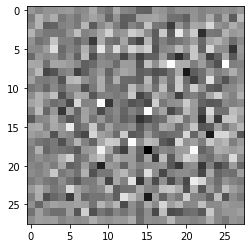

In [17]:
plt.imshow(result[0,:,:,0], cmap='gray')

print('Value range in image: ', np.min(result[0,:,:,0]), np.max(result[0,:,:,0]))

##Training

**Loss for normal GAN**


In [18]:
# we use binary cross entropy loss for both the generator and discriminator
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(output_real_image, output_fake_image):
  """
  The discriminator loss is the sum of the loss of fake images and the loss 
  of real images.
  Correct labels for real and fake images are constructed using zeros_like 
  (for fake images) and ones_like (for real images).

  output_real_image:  classifications of one batch of real images
  output_fake_image:  classifications of one batch of fake images
  """
  loss_real = BCE(tf.ones_like(output_real_image), output_real_image)
  loss_fake = BCE(tf.zeros_like(output_fake_image), output_fake_image)

  return loss_real + loss_fake


def generator_loss(output_fake_image):
  """
  The generator loss is the loss of the fake images it created.
  
  output_fake_image:  classifications of one batch of fake images
  """
  loss = BCE(tf.ones_like(output_fake_image), output_fake_image)

  return loss

**Loss for Wasserstein GAN**

In [19]:
def w_discriminator_loss(output_real_image, output_fake_image):
  """
  Wasserstein loss for the discriminator: Sum of losses for real and fake 
  images which are just the mean for all discriminator outputs of the respective 
  group (negative mean for the real images).

  output_real_image:  classifications of one batch of real images
  output_fake_image:  classifications of one batch of fake images
  """
  loss_real = - tf.reduce_mean(output_real_image)
  loss_fake = tf.reduce_mean(output_fake_image)

  return loss_real + loss_fake

def w_generator_loss(output_fake_image):
  """
  Wasserstein loss for the generator is the mean of the output multiplied by -1.
  
  output_fake_image:  classifications of one batch of fake images
  """

  loss_fake = - tf.reduce_mean(output_fake_image)

  return loss_fake

**Train step and Test step**

define training step function and testing step function

In [20]:
def train_step(generator, discriminator, input, g_loss, d_loss, optimizer_generator, optimizer_discriminator):
  """
  Perform one training step
  generator:                    current generator
  discriminator:                current discriminator
  input:                        the input image that is fed into the discriminator
  g_loss:                       generator loss function
  d_loss:                       discriminator loss function
  optimizer_generator:          optimizer for the generator
  optimizer_discriminator:      optimizer for the discriminator
  Return:                       mean losses for generator and discriminator
  """

  # Create random vector that is used as input for the generator 
  input_generator =  tf.random.normal([BATCH_SIZE, LATENTSPACE_SIZE])

  with tf.GradientTape() as tape_generator, tf.GradientTape() as tape_disriminator:

    # generate an image with the generator
    fake_image = generator(input_generator)

    # feed both the real and the fake batch into the discriminator
    output_real_image = discriminator(input)
    output_fake_image = discriminator(fake_image)

    # Compute losses
    loss_discriminator = d_loss(output_real_image, output_fake_image)
    loss_generator = g_loss(output_fake_image)

    gradients_discriminator = tape_disriminator.gradient(loss_discriminator, discriminator.trainable_variables)
    gradients_generator = tape_generator.gradient(loss_generator, generator.trainable_variables)

  # Adapt network
  optimizer_discriminator.apply_gradients(zip(gradients_discriminator, discriminator.trainable_variables))
  optimizer_generator.apply_gradients(zip(gradients_generator, generator.trainable_variables))

  return np.mean(loss_discriminator), np.mean(loss_generator)


def test(generator, discriminator, g_loss, d_loss, test_vectors):
  """
  Test models over test data (real and fake data.)
  generator:          current generator
  discriminator:      current discriminator
  g_loss:             generator loss function
  d_loss:             discriminator loss function
  test_vectors:       latent space vectors to generate images with generator
  """

  generated_images = generator(test_vectors, is_training=False)
  testing_images = make_test_data()

  # plot the generated images
  _, ax = plt.subplots(1, 10, figsize=(25, 5))

  for i in range(10):
    img = ((generated_images[i,:,:,0] + 1) / 2) * 255   # transfer back to range[0,255]
    ax[i].imshow(img, cmap='gray') ; ax[i].axis('off')
  
  plt.show()

  output_fake_image = discriminator(generated_images, is_training=False)

  # Test set contains one batch of real images
  for input in testing_images:
    output_real_image = discriminator(input, is_training=False)
  
  # Calculate the losses for both models with the respective functions
  loss_discriminator = d_loss(output_real_image, output_fake_image)
  loss_generator = g_loss(output_fake_image)

  return loss_discriminator, loss_generator

In [21]:
def train(num_epochs, generator, discriminator, g_loss, d_loss, optimizer_generator, optimizer_discriminator):
  """
  Function to train a network (containing train and test steps).
  num_epochs:               number of epochs to train
  generator:                current generator
  discriminator:            current discriminator
  g_loss:                   loss function of generator
  d_loss:                   loss function of discriminator
  optimizer_generator:      optimizer used for the generator
  optimizer_discriminator:  optimizer used for the generator
  """
  # To keep track of all losses for visualisation
  train_losses_g_all, train_losses_d_all = [], []

  for epoch in range(num_epochs):

    # Track epoch and time while code runs
    start = time.time()
    print('Epoch: __ ' + str(epoch+1))

    # Training (and checking in with training loss of both discriminator 
    # and generator)
    running_average_loss_discriminator = 0
    running_average_loss_generator = 0

    # Iterate over all training images
    for itr, input in enumerate(train_imgs):
      
      # Perform one training step and update discriminator + generator losses
      train_loss_discriminator, train_loss_generator = train_step(generator, discriminator, input, g_loss, d_loss, optimizer_generator, optimizer_discriminator)

      # save losses for visualisation later
      train_losses_d_all.append(train_loss_discriminator)
      train_losses_g_all.append(train_loss_generator)

      running_average_loss_discriminator = running_average_factor * running_average_loss_discriminator  + (1 - running_average_factor) * train_loss_discriminator
      running_average_loss_generator = running_average_factor * running_average_loss_generator  + (1 - running_average_factor) * train_loss_generator
    
      # Print loss always after the next 100 steps within epoch to keep track 
      # of loss changes during training
      if itr % 100 == 0 and itr > 0:
        print('Iteration #%s - Discriminator loss: %s, Generator loss: %s' % (itr, round(train_loss_discriminator, 4), round(train_loss_generator, 4)))

    train_losses_discriminator.append(running_average_loss_discriminator)
    train_losses_generator.append(running_average_loss_generator)

    # Testing 
    test_loss_discriminator, test_loss_generator = test(generator, discriminator, g_loss, d_loss, test_vectors)
    test_losses_discriminator.append(test_loss_discriminator)
    test_losses_generator.append(test_loss_generator)

    duration = time.time() - start

    # Measure time required for each epoch
    print('... finished after %s seconds ' % round(duration, 2))

  return train_losses_discriminator, test_losses_discriminator, train_losses_generator, test_losses_generator, train_losses_g_all, train_losses_d_all

In [22]:
def plot(train_losses_d, test_losses_d, train_losses_g, test_losses_g, train_losses_g_all, train_losses_d_all):
  """
  Function for plotting all losses obtained during training and testing the 
  models.

  train_losses_d:       Discriminator losses (training) - per epoch
  test_losses_d:        Discriminator losses (testing) - per epoch
  train_losses_g:       Generator losses (training) - per epoch
  test_losses_g:        Generator losses (testing) - per epoch
  train_losses_g_all:   Generator losses (training) - for every step in epoch
  train_losses_d_all:   Discriminator losses (training) - for every step in epoch
  """
  # Plot loss of the discriminator
  plt.figure(figsize=(20,5))
  plt.plot(train_losses_d, label="train")
  plt.plot(test_losses_d, label="test")
  plt.legend()
  plt.title("Loss Discriminator")
  plt.show()

  # Plot loss of the generator
  plt.figure(figsize=(20,5))
  plt.plot(train_losses_g, label="train")
  plt.plot(test_losses_g, label="test")
  plt.legend()
  plt.title("Loss Generator")
  plt.show()

  # Compare the losses of generator and discriminator throughout the whole 
  # training process
  plt.figure(figsize=(20,5))
  plt.plot(train_losses_g_all, label="Generator")
  plt.plot(train_losses_d_all, label="Discriminator")
  plt.legend()
  plt.title("Generator Loss vs Discriminator Loss")
  plt.show()


**Setup for training**

For training without the WGAN adjustments we chose:
* a learning rate of 0.00001
* binary crossentropy as the discriminator loss
* optimizer: Adam

In [36]:
K.clear_session()
# Use wasserstein (True) or not (False)
WASSERSTEIN = False

# Hyperparameters for training
num_epochs = 20
learning_rate = 0.00001
running_average_factor = 0.95

# Initialize discriminator and generator
discriminator = Discriminator(wasserstein=WASSERSTEIN)
generator = Generator()

# Adam optimizer
optimizer_discriminator = tf.keras.optimizers.Adam(learning_rate)
optimizer_generator = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for visualization.
train_losses_discriminator, train_losses_generator = [], []
test_losses_discriminator, test_losses_generator = [], []

**Start training**


Epoch: __ 1
Iteration #100 - Discriminator loss: 1.4354, Generator loss: 0.4675
Iteration #200 - Discriminator loss: 1.4168, Generator loss: 0.4633
Iteration #300 - Discriminator loss: 1.4169, Generator loss: 0.4538
Iteration #400 - Discriminator loss: 1.4203, Generator loss: 0.445
Iteration #500 - Discriminator loss: 1.4313, Generator loss: 0.4395
Iteration #600 - Discriminator loss: 1.4486, Generator loss: 0.4295
Iteration #700 - Discriminator loss: 1.4635, Generator loss: 0.4288
Iteration #800 - Discriminator loss: 1.4601, Generator loss: 0.434
Iteration #900 - Discriminator loss: 1.4596, Generator loss: 0.4403


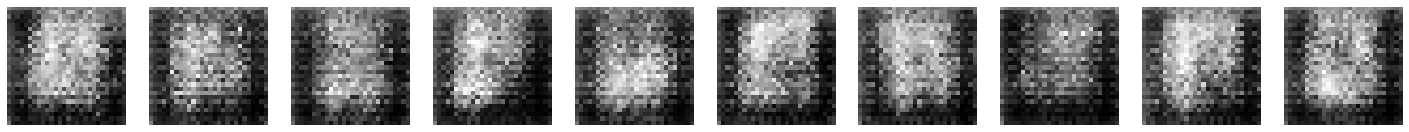

... finished after 31.49 seconds 
Epoch: __ 2
Iteration #100 - Discriminator loss: 1.4332, Generator loss: 0.4619
Iteration #200 - Discriminator loss: 1.4091, Generator loss: 0.481
Iteration #300 - Discriminator loss: 1.4325, Generator loss: 0.4701
Iteration #400 - Discriminator loss: 1.4803, Generator loss: 0.4469
Iteration #500 - Discriminator loss: 1.4856, Generator loss: 0.4429
Iteration #600 - Discriminator loss: 1.4681, Generator loss: 0.4553
Iteration #700 - Discriminator loss: 1.4596, Generator loss: 0.4606
Iteration #800 - Discriminator loss: 1.4512, Generator loss: 0.4604
Iteration #900 - Discriminator loss: 1.4359, Generator loss: 0.4624


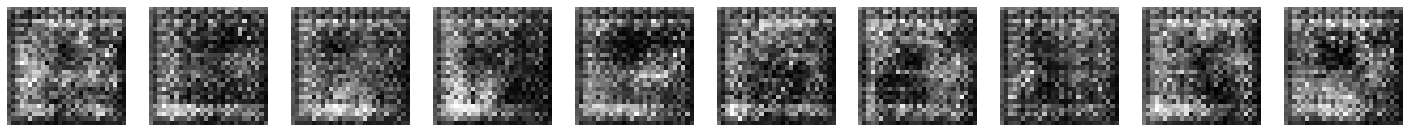

... finished after 30.48 seconds 
Epoch: __ 3
Iteration #100 - Discriminator loss: 1.4334, Generator loss: 0.4558
Iteration #200 - Discriminator loss: 1.4679, Generator loss: 0.434
Iteration #300 - Discriminator loss: 1.4692, Generator loss: 0.4336
Iteration #400 - Discriminator loss: 1.442, Generator loss: 0.4571
Iteration #500 - Discriminator loss: 1.4219, Generator loss: 0.4786
Iteration #600 - Discriminator loss: 1.4404, Generator loss: 0.4864
Iteration #700 - Discriminator loss: 1.4453, Generator loss: 0.5027
Iteration #800 - Discriminator loss: 1.4432, Generator loss: 0.5105
Iteration #900 - Discriminator loss: 1.4483, Generator loss: 0.5082


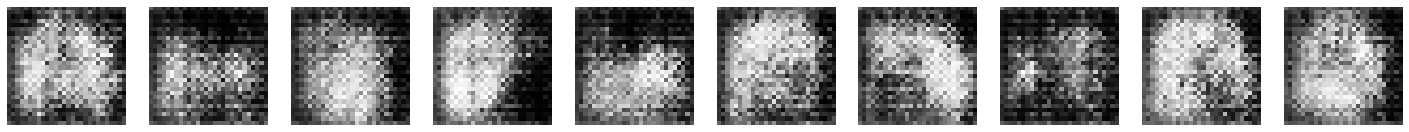

... finished after 30.59 seconds 
Epoch: __ 4
Iteration #100 - Discriminator loss: 1.4237, Generator loss: 0.5182
Iteration #200 - Discriminator loss: 1.4389, Generator loss: 0.4975
Iteration #300 - Discriminator loss: 1.4493, Generator loss: 0.492
Iteration #400 - Discriminator loss: 1.4409, Generator loss: 0.5008
Iteration #500 - Discriminator loss: 1.4363, Generator loss: 0.5072
Iteration #600 - Discriminator loss: 1.4273, Generator loss: 0.5094
Iteration #700 - Discriminator loss: 1.4294, Generator loss: 0.5064
Iteration #800 - Discriminator loss: 1.4321, Generator loss: 0.5125
Iteration #900 - Discriminator loss: 1.4329, Generator loss: 0.524


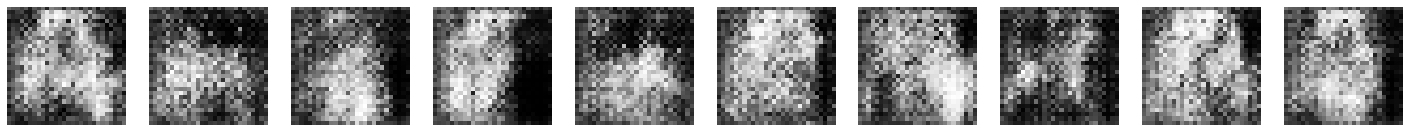

... finished after 30.47 seconds 
Epoch: __ 5
Iteration #100 - Discriminator loss: 1.4218, Generator loss: 0.5317
Iteration #200 - Discriminator loss: 1.4133, Generator loss: 0.5335
Iteration #300 - Discriminator loss: 1.4166, Generator loss: 0.5518
Iteration #400 - Discriminator loss: 1.415, Generator loss: 0.5681
Iteration #500 - Discriminator loss: 1.4199, Generator loss: 0.5662
Iteration #600 - Discriminator loss: 1.4041, Generator loss: 0.5636
Iteration #700 - Discriminator loss: 1.4094, Generator loss: 0.5736
Iteration #800 - Discriminator loss: 1.3963, Generator loss: 0.6021
Iteration #900 - Discriminator loss: 1.417, Generator loss: 0.5859


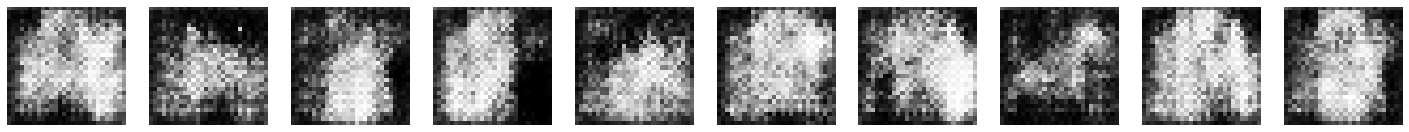

... finished after 30.46 seconds 
Epoch: __ 6
Iteration #100 - Discriminator loss: 1.3798, Generator loss: 0.568
Iteration #200 - Discriminator loss: 1.4163, Generator loss: 0.5677
Iteration #300 - Discriminator loss: 1.3949, Generator loss: 0.6224
Iteration #400 - Discriminator loss: 1.4011, Generator loss: 0.6168
Iteration #500 - Discriminator loss: 1.4045, Generator loss: 0.6097
Iteration #600 - Discriminator loss: 1.3851, Generator loss: 0.6022
Iteration #700 - Discriminator loss: 1.3919, Generator loss: 0.6025
Iteration #800 - Discriminator loss: 1.3936, Generator loss: 0.6298
Iteration #900 - Discriminator loss: 1.3916, Generator loss: 0.6421


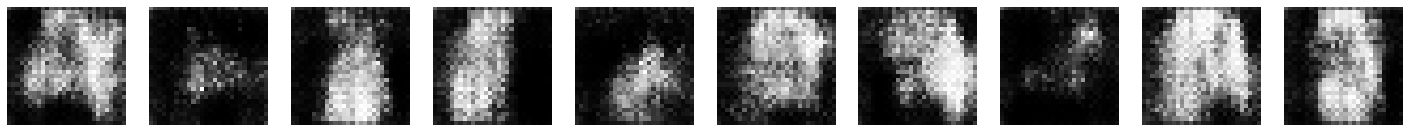

... finished after 30.56 seconds 
Epoch: __ 7
Iteration #100 - Discriminator loss: 1.398, Generator loss: 0.6442
Iteration #200 - Discriminator loss: 1.3971, Generator loss: 0.6432
Iteration #300 - Discriminator loss: 1.3963, Generator loss: 0.6459
Iteration #400 - Discriminator loss: 1.3961, Generator loss: 0.6451
Iteration #500 - Discriminator loss: 1.3937, Generator loss: 0.6445
Iteration #600 - Discriminator loss: 1.3921, Generator loss: 0.6482
Iteration #700 - Discriminator loss: 1.389, Generator loss: 0.653
Iteration #800 - Discriminator loss: 1.3894, Generator loss: 0.6541
Iteration #900 - Discriminator loss: 1.39, Generator loss: 0.6528


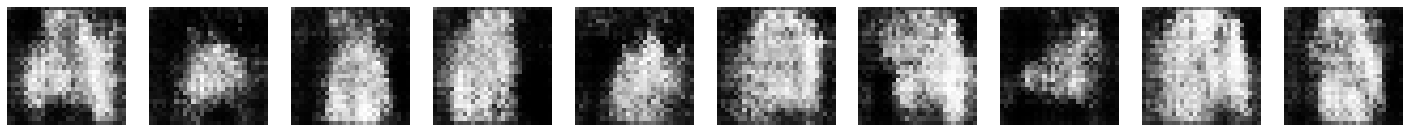

... finished after 31.29 seconds 
Epoch: __ 8
Iteration #100 - Discriminator loss: 1.3951, Generator loss: 0.6466
Iteration #200 - Discriminator loss: 1.3901, Generator loss: 0.6542
Iteration #300 - Discriminator loss: 1.3909, Generator loss: 0.6641
Iteration #400 - Discriminator loss: 1.3902, Generator loss: 0.6698
Iteration #500 - Discriminator loss: 1.3884, Generator loss: 0.6715
Iteration #600 - Discriminator loss: 1.3889, Generator loss: 0.6712
Iteration #700 - Discriminator loss: 1.3879, Generator loss: 0.6685
Iteration #800 - Discriminator loss: 1.3887, Generator loss: 0.6685
Iteration #900 - Discriminator loss: 1.3889, Generator loss: 0.675


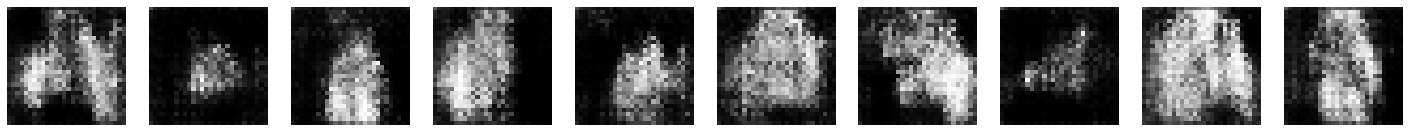

... finished after 30.49 seconds 
Epoch: __ 9
Iteration #100 - Discriminator loss: 1.3897, Generator loss: 0.6782
Iteration #200 - Discriminator loss: 1.389, Generator loss: 0.6787
Iteration #300 - Discriminator loss: 1.3885, Generator loss: 0.6798
Iteration #400 - Discriminator loss: 1.3899, Generator loss: 0.6789
Iteration #500 - Discriminator loss: 1.3882, Generator loss: 0.6782
Iteration #600 - Discriminator loss: 1.3894, Generator loss: 0.678
Iteration #700 - Discriminator loss: 1.3876, Generator loss: 0.681
Iteration #800 - Discriminator loss: 1.3874, Generator loss: 0.6812
Iteration #900 - Discriminator loss: 1.3865, Generator loss: 0.6791


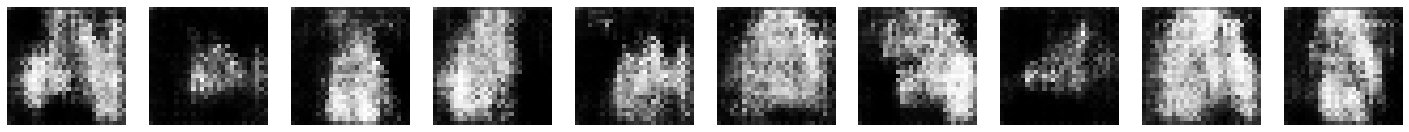

... finished after 29.95 seconds 
Epoch: __ 10
Iteration #100 - Discriminator loss: 1.3854, Generator loss: 0.6734
Iteration #200 - Discriminator loss: 1.386, Generator loss: 0.6732
Iteration #300 - Discriminator loss: 1.386, Generator loss: 0.6757
Iteration #400 - Discriminator loss: 1.3861, Generator loss: 0.6807
Iteration #500 - Discriminator loss: 1.3869, Generator loss: 0.6824
Iteration #600 - Discriminator loss: 1.3881, Generator loss: 0.683
Iteration #700 - Discriminator loss: 1.387, Generator loss: 0.6853
Iteration #800 - Discriminator loss: 1.3876, Generator loss: 0.6861
Iteration #900 - Discriminator loss: 1.387, Generator loss: 0.6873


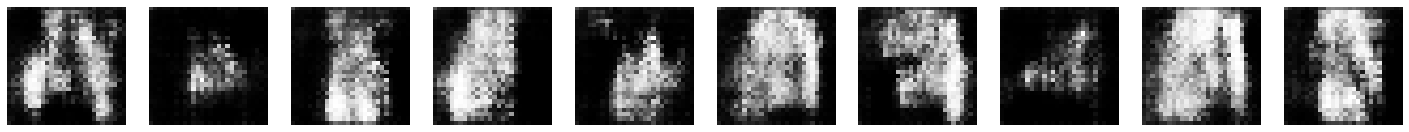

... finished after 30.01 seconds 
Epoch: __ 11
Iteration #100 - Discriminator loss: 1.3874, Generator loss: 0.6885
Iteration #200 - Discriminator loss: 1.3872, Generator loss: 0.6889
Iteration #300 - Discriminator loss: 1.3873, Generator loss: 0.6892
Iteration #400 - Discriminator loss: 1.3869, Generator loss: 0.6899
Iteration #500 - Discriminator loss: 1.3872, Generator loss: 0.6901
Iteration #600 - Discriminator loss: 1.387, Generator loss: 0.6905
Iteration #700 - Discriminator loss: 1.3868, Generator loss: 0.6907
Iteration #800 - Discriminator loss: 1.387, Generator loss: 0.6908
Iteration #900 - Discriminator loss: 1.3869, Generator loss: 0.6908


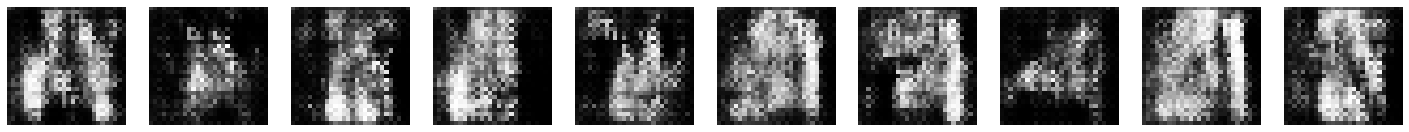

... finished after 29.55 seconds 
Epoch: __ 12
Iteration #100 - Discriminator loss: 1.3867, Generator loss: 0.6906
Iteration #200 - Discriminator loss: 1.3864, Generator loss: 0.6896
Iteration #300 - Discriminator loss: 1.3869, Generator loss: 0.6902
Iteration #400 - Discriminator loss: 1.3864, Generator loss: 0.6916
Iteration #500 - Discriminator loss: 1.3863, Generator loss: 0.692
Iteration #600 - Discriminator loss: 1.3864, Generator loss: 0.6919
Iteration #700 - Discriminator loss: 1.3866, Generator loss: 0.6919
Iteration #800 - Discriminator loss: 1.3866, Generator loss: 0.6918
Iteration #900 - Discriminator loss: 1.3868, Generator loss: 0.6917


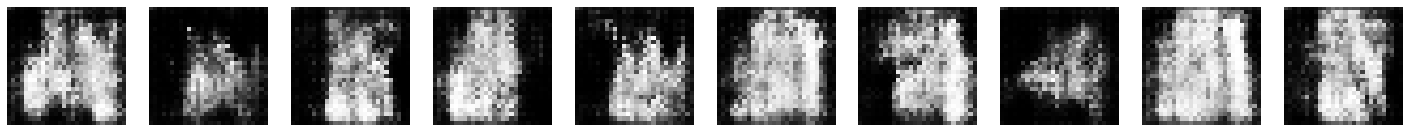

... finished after 29.29 seconds 
Epoch: __ 13
Iteration #100 - Discriminator loss: 1.3865, Generator loss: 0.6919
Iteration #200 - Discriminator loss: 1.3864, Generator loss: 0.692
Iteration #300 - Discriminator loss: 1.3862, Generator loss: 0.6916
Iteration #400 - Discriminator loss: 1.3872, Generator loss: 0.6891
Iteration #500 - Discriminator loss: 1.3864, Generator loss: 0.692
Iteration #600 - Discriminator loss: 1.3864, Generator loss: 0.6922
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.6924
Iteration #800 - Discriminator loss: 1.3864, Generator loss: 0.6925
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.6925


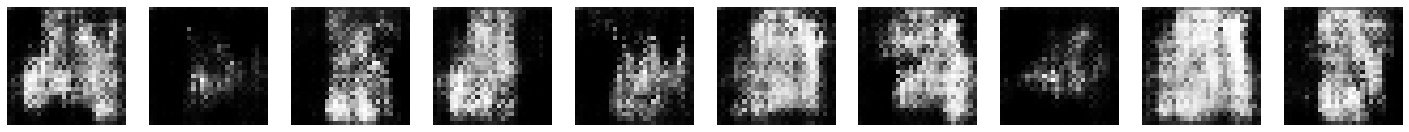

... finished after 29.64 seconds 
Epoch: __ 14
Iteration #100 - Discriminator loss: 1.3864, Generator loss: 0.6926
Iteration #200 - Discriminator loss: 1.3864, Generator loss: 0.6925
Iteration #300 - Discriminator loss: 1.3864, Generator loss: 0.6926
Iteration #400 - Discriminator loss: 1.3864, Generator loss: 0.6926
Iteration #500 - Discriminator loss: 1.3864, Generator loss: 0.6927
Iteration #600 - Discriminator loss: 1.3863, Generator loss: 0.6927
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.6927
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6927
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.6928


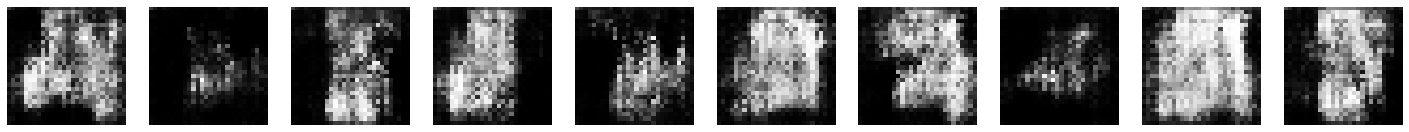

... finished after 29.03 seconds 
Epoch: __ 15
Iteration #100 - Discriminator loss: 1.3863, Generator loss: 0.6928
Iteration #200 - Discriminator loss: 1.3864, Generator loss: 0.6928
Iteration #300 - Discriminator loss: 1.3863, Generator loss: 0.6928
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.6928
Iteration #500 - Discriminator loss: 1.3863, Generator loss: 0.6928
Iteration #600 - Discriminator loss: 1.3864, Generator loss: 0.6928
Iteration #700 - Discriminator loss: 1.3864, Generator loss: 0.6928
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6929
Iteration #900 - Discriminator loss: 1.3864, Generator loss: 0.6929


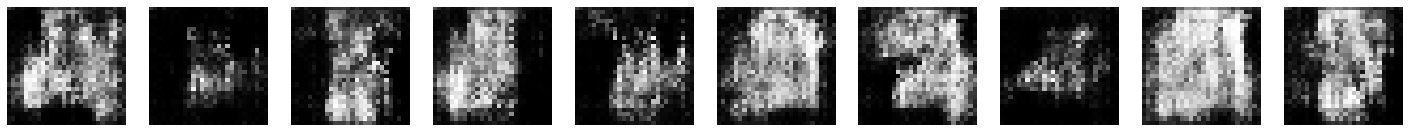

... finished after 28.89 seconds 
Epoch: __ 16
Iteration #100 - Discriminator loss: 1.3863, Generator loss: 0.6929
Iteration #200 - Discriminator loss: 1.3864, Generator loss: 0.6929
Iteration #300 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #500 - Discriminator loss: 1.3864, Generator loss: 0.693
Iteration #600 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.693


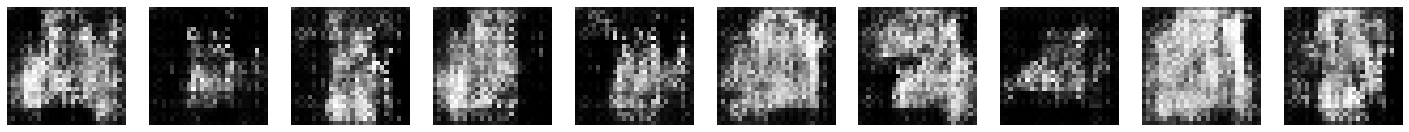

... finished after 28.48 seconds 
Epoch: __ 17
Iteration #100 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #200 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #300 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #500 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #600 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.693


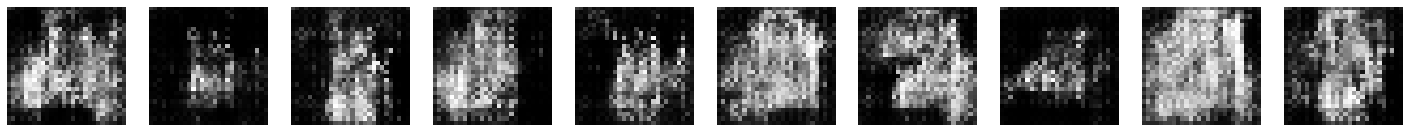

... finished after 28.64 seconds 
Epoch: __ 18
Iteration #100 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #200 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #300 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #500 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #600 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.693


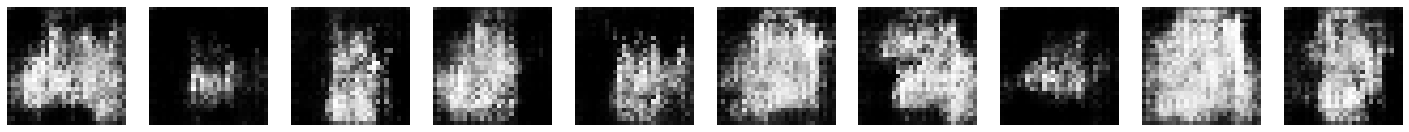

... finished after 28.72 seconds 
Epoch: __ 19
Iteration #100 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #200 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #300 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.693
Iteration #500 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #600 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.6931


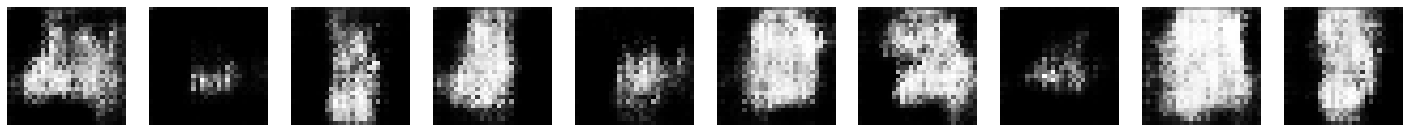

... finished after 27.96 seconds 
Epoch: __ 20
Iteration #100 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #200 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #300 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #400 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #500 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #600 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #700 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #800 - Discriminator loss: 1.3863, Generator loss: 0.6931
Iteration #900 - Discriminator loss: 1.3863, Generator loss: 0.6931


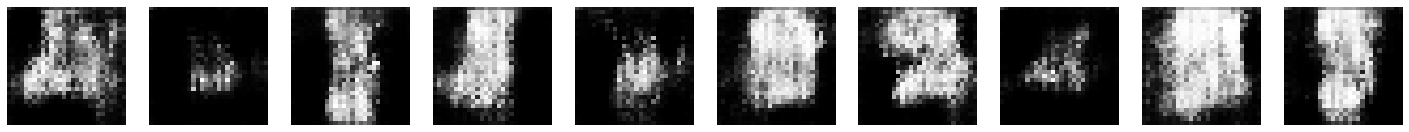

... finished after 27.86 seconds 


In [37]:
train_losses_d, test_losses_d, train_losses_g, test_losses_g, train_losses_g_all, train_losses_d_all = train(
    num_epochs=num_epochs, 
    generator=generator, 
    discriminator=discriminator, 
    g_loss=generator_loss, 
    d_loss=discriminator_loss, 
    optimizer_generator=optimizer_generator, 
    optimizer_discriminator=optimizer_discriminator)

**Evaluation of GAN**

Taking a look at the images produced by the generator, one can see that so far we are only able to create indistinguishable white blobs on black background. The following plot shows how the losses do not really change during the last epochs (no changes from epoch 16 on). Further improvement must be done - in the next section we will see whether WGAN improves our results.

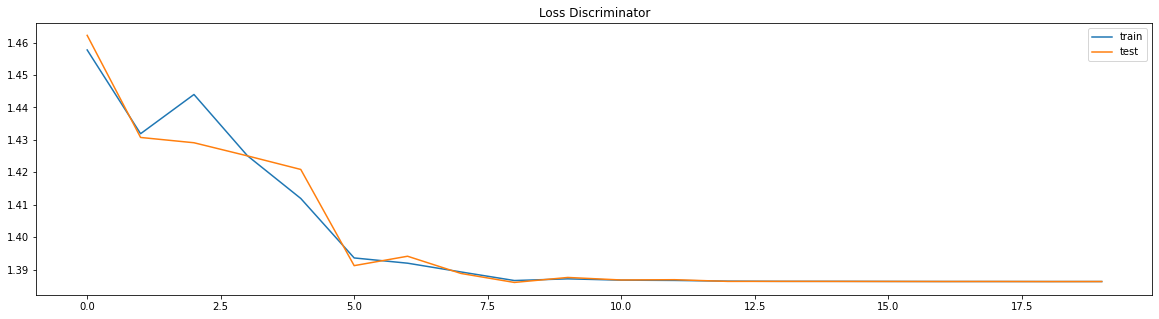

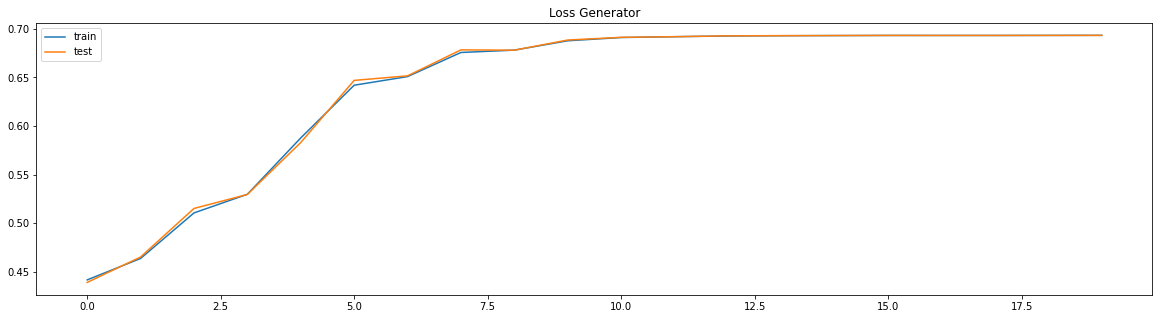

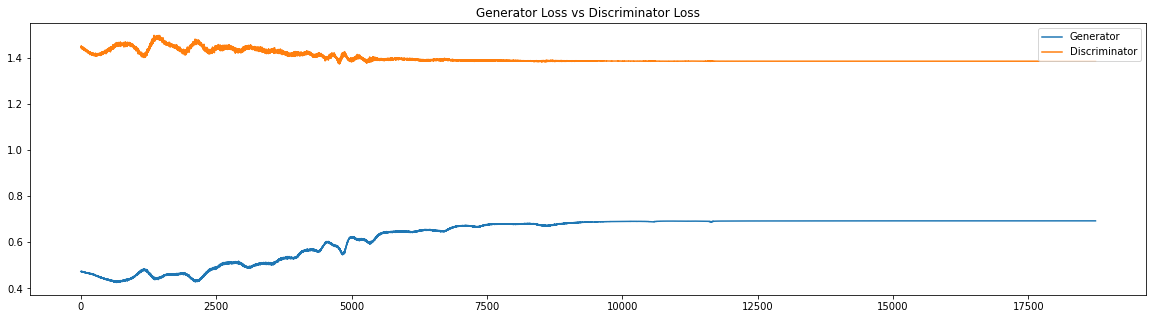

In [40]:
plot(train_losses_d, test_losses_d, train_losses_g, test_losses_g, train_losses_g_all, train_losses_d_all)

**Setup for training  (WGAN)**

For training with WGAN adjustments we chose:
* a learning rate of 0.00005
* Wasserstein loss for discriminator
* optimizer: RMSprop
* weight clipping in the Discriminator (Wasserstein adaption is allowed through the boolean 'wasserstein' when initialising the discriminator -> True will yield the Wasserstein discriminator, False will yield the 'normal' discriminator)

In [46]:
K.clear_session()

# Use wasserstein (True) or not (False)
WASSERSTEIN = True

# Hyperparameters for training
num_epochs = 20
learning_rate = 0.00005
running_average_factor = 0.95

# Initializing discriminator (passing 'true' to initialize the Wasserstein 
# discriminator -> weight clipping) and generator
discriminator = Discriminator(wasserstein=WASSERSTEIN)
generator = Generator()

# Adam optimizer
optimizer_discriminator = tf.keras.optimizers.RMSprop(learning_rate)
optimizer_generator = tf.keras.optimizers.RMSprop(learning_rate)

# Initialize lists for visualization.
train_losses_discriminator, train_losses_generator = [], []
test_losses_discriminator, test_losses_generator = [], []

Epoch: __ 1
Iteration #100 - Discriminator loss: -0.0855, Generator loss: -0.0739
Iteration #200 - Discriminator loss: -0.0263, Generator loss: -0.0989
Iteration #300 - Discriminator loss: -0.048, Generator loss: -0.021
Iteration #400 - Discriminator loss: -0.0246, Generator loss: -0.0532
Iteration #500 - Discriminator loss: -0.0091, Generator loss: -0.0426
Iteration #600 - Discriminator loss: -0.008, Generator loss: -0.034
Iteration #700 - Discriminator loss: -0.0009, Generator loss: -0.0472
Iteration #800 - Discriminator loss: -0.0024, Generator loss: -0.048
Iteration #900 - Discriminator loss: -0.006, Generator loss: -0.0225


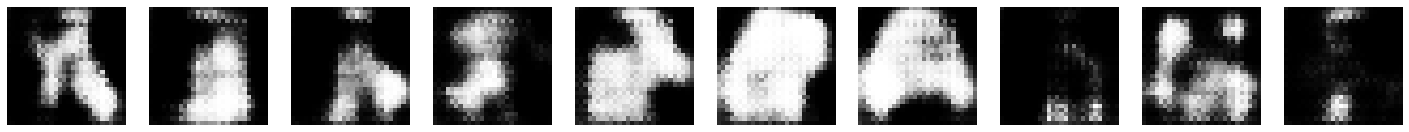

... finished after 35.22 seconds 
Epoch: __ 2
Iteration #100 - Discriminator loss: -0.0048, Generator loss: -0.0173
Iteration #200 - Discriminator loss: -0.006, Generator loss: -0.0129
Iteration #300 - Discriminator loss: -0.0045, Generator loss: -0.0254
Iteration #400 - Discriminator loss: -0.0055, Generator loss: -0.0288
Iteration #500 - Discriminator loss: -0.0086, Generator loss: -0.0229
Iteration #600 - Discriminator loss: -0.0069, Generator loss: -0.0351
Iteration #700 - Discriminator loss: -0.0061, Generator loss: -0.0379
Iteration #800 - Discriminator loss: -0.004, Generator loss: -0.0471
Iteration #900 - Discriminator loss: -0.0053, Generator loss: -0.0393


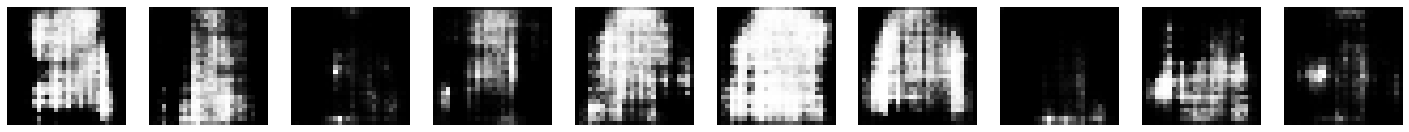

... finished after 34.04 seconds 
Epoch: __ 3
Iteration #100 - Discriminator loss: -0.0056, Generator loss: -0.0406
Iteration #200 - Discriminator loss: -0.0033, Generator loss: -0.0325
Iteration #300 - Discriminator loss: -0.008, Generator loss: -0.0366
Iteration #400 - Discriminator loss: -0.0114, Generator loss: -0.0107
Iteration #500 - Discriminator loss: -0.01, Generator loss: -0.0379
Iteration #600 - Discriminator loss: -0.0065, Generator loss: -0.0262
Iteration #700 - Discriminator loss: 0.0015, Generator loss: -0.0744
Iteration #800 - Discriminator loss: -0.0068, Generator loss: -0.0709
Iteration #900 - Discriminator loss: -0.0205, Generator loss: -0.0727


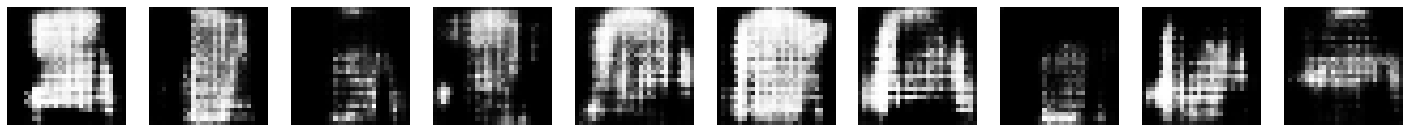

... finished after 34.21 seconds 
Epoch: __ 4
Iteration #100 - Discriminator loss: -0.0113, Generator loss: -0.0079
Iteration #200 - Discriminator loss: -0.0083, Generator loss: -0.0044
Iteration #300 - Discriminator loss: -0.0109, Generator loss: -0.0547
Iteration #400 - Discriminator loss: 0.0142, Generator loss: -0.1185
Iteration #500 - Discriminator loss: -0.0079, Generator loss: -0.0908
Iteration #600 - Discriminator loss: -0.01, Generator loss: -0.0598
Iteration #700 - Discriminator loss: -0.0125, Generator loss: -0.0061
Iteration #800 - Discriminator loss: -0.008, Generator loss: -0.1083
Iteration #900 - Discriminator loss: -0.0086, Generator loss: -0.0103


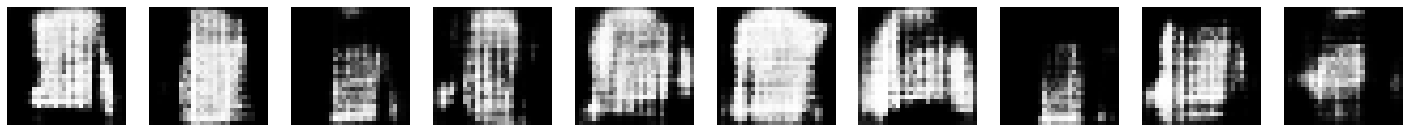

... finished after 34.17 seconds 
Epoch: __ 5
Iteration #100 - Discriminator loss: -0.0116, Generator loss: -0.0174
Iteration #200 - Discriminator loss: -0.0178, Generator loss: -0.0077
Iteration #300 - Discriminator loss: -0.0181, Generator loss: -0.0666
Iteration #400 - Discriminator loss: -0.008, Generator loss: -0.0928
Iteration #500 - Discriminator loss: 0.028, Generator loss: -0.1942
Iteration #600 - Discriminator loss: -0.015, Generator loss: -0.0544
Iteration #700 - Discriminator loss: -0.0134, Generator loss: -0.0628
Iteration #800 - Discriminator loss: -0.0274, Generator loss: -0.056
Iteration #900 - Discriminator loss: -0.0088, Generator loss: -0.0092


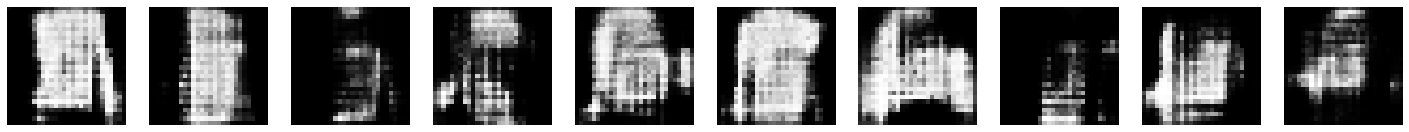

... finished after 33.54 seconds 
Epoch: __ 6
Iteration #100 - Discriminator loss: -0.0231, Generator loss: -0.0492
Iteration #200 - Discriminator loss: -0.0097, Generator loss: -0.0358
Iteration #300 - Discriminator loss: 0.001, Generator loss: -0.1223
Iteration #400 - Discriminator loss: -0.0355, Generator loss: -0.1448
Iteration #500 - Discriminator loss: -0.0014, Generator loss: 0.0284
Iteration #600 - Discriminator loss: -0.0057, Generator loss: -0.1308
Iteration #700 - Discriminator loss: -0.0199, Generator loss: -0.0977
Iteration #800 - Discriminator loss: -0.0159, Generator loss: -0.054
Iteration #900 - Discriminator loss: -0.0138, Generator loss: -0.0613


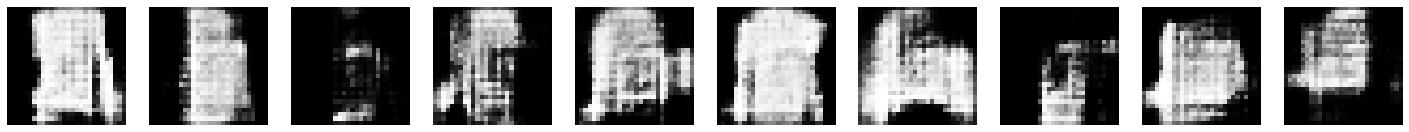

... finished after 33.8 seconds 
Epoch: __ 7
Iteration #100 - Discriminator loss: -0.0146, Generator loss: 0.0379
Iteration #200 - Discriminator loss: -0.0139, Generator loss: 0.0434
Iteration #300 - Discriminator loss: -0.0086, Generator loss: -0.1518
Iteration #400 - Discriminator loss: -0.0259, Generator loss: 0.0232
Iteration #500 - Discriminator loss: 0.004, Generator loss: -0.1501
Iteration #600 - Discriminator loss: -0.0203, Generator loss: -0.0979
Iteration #700 - Discriminator loss: -0.019, Generator loss: -0.0608
Iteration #800 - Discriminator loss: -0.0245, Generator loss: -0.029
Iteration #900 - Discriminator loss: -0.0219, Generator loss: -0.0537


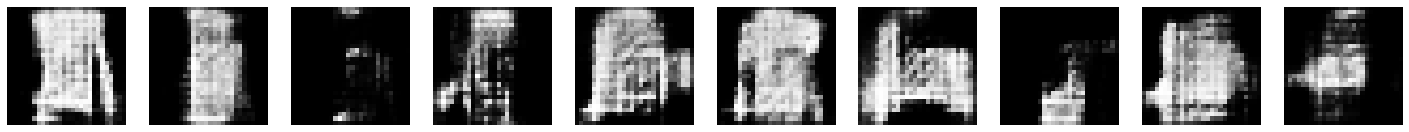

... finished after 32.89 seconds 
Epoch: __ 8
Iteration #100 - Discriminator loss: -0.0115, Generator loss: 0.0055
Iteration #200 - Discriminator loss: -0.0173, Generator loss: -0.0408
Iteration #300 - Discriminator loss: -0.0418, Generator loss: -0.1091
Iteration #400 - Discriminator loss: -0.0119, Generator loss: -0.1746
Iteration #500 - Discriminator loss: -0.0264, Generator loss: -0.0595
Iteration #600 - Discriminator loss: -0.0265, Generator loss: -0.1642
Iteration #700 - Discriminator loss: -0.0149, Generator loss: -0.0405
Iteration #800 - Discriminator loss: -0.0116, Generator loss: -0.1502
Iteration #900 - Discriminator loss: -0.0164, Generator loss: -0.0923


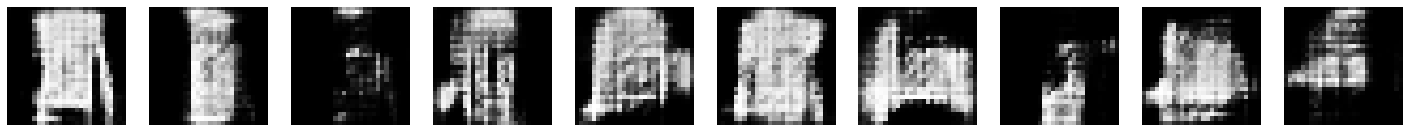

... finished after 32.66 seconds 
Epoch: __ 9
Iteration #100 - Discriminator loss: -0.0151, Generator loss: -0.0072
Iteration #200 - Discriminator loss: -0.0192, Generator loss: -0.086
Iteration #300 - Discriminator loss: -0.0272, Generator loss: -0.1029
Iteration #400 - Discriminator loss: -0.0271, Generator loss: -0.0168
Iteration #500 - Discriminator loss: -0.0113, Generator loss: -0.1231
Iteration #600 - Discriminator loss: -0.0091, Generator loss: -0.128
Iteration #700 - Discriminator loss: -0.0154, Generator loss: -0.0819
Iteration #800 - Discriminator loss: -0.0144, Generator loss: -0.0845
Iteration #900 - Discriminator loss: -0.0021, Generator loss: -0.0315


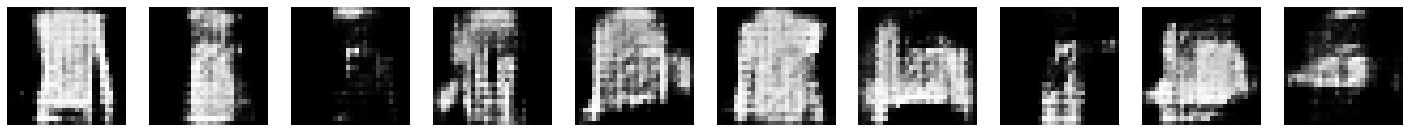

... finished after 32.29 seconds 
Epoch: __ 10
Iteration #100 - Discriminator loss: -0.0104, Generator loss: -0.0452
Iteration #200 - Discriminator loss: -0.0129, Generator loss: 0.0284
Iteration #300 - Discriminator loss: -0.0202, Generator loss: -0.0995
Iteration #400 - Discriminator loss: -0.0109, Generator loss: -0.02
Iteration #500 - Discriminator loss: -0.02, Generator loss: 0.0379
Iteration #600 - Discriminator loss: -0.0313, Generator loss: 0.0307
Iteration #700 - Discriminator loss: -0.012, Generator loss: -0.1105
Iteration #800 - Discriminator loss: -0.0113, Generator loss: -0.084
Iteration #900 - Discriminator loss: -0.0213, Generator loss: -0.027


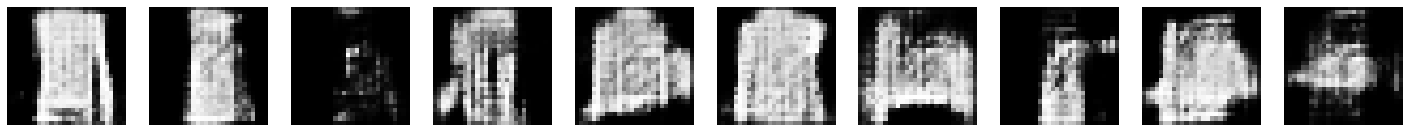

... finished after 32.39 seconds 
Epoch: __ 11
Iteration #100 - Discriminator loss: -0.0109, Generator loss: -0.1663
Iteration #200 - Discriminator loss: -0.0325, Generator loss: 0.0993
Iteration #300 - Discriminator loss: -0.0195, Generator loss: -0.0841
Iteration #400 - Discriminator loss: -0.0755, Generator loss: 0.1406
Iteration #500 - Discriminator loss: -0.0039, Generator loss: -0.1588
Iteration #600 - Discriminator loss: -0.014, Generator loss: 0.0216
Iteration #700 - Discriminator loss: -0.0044, Generator loss: -0.1615
Iteration #800 - Discriminator loss: -0.0284, Generator loss: 0.0475
Iteration #900 - Discriminator loss: -0.0136, Generator loss: -0.0683


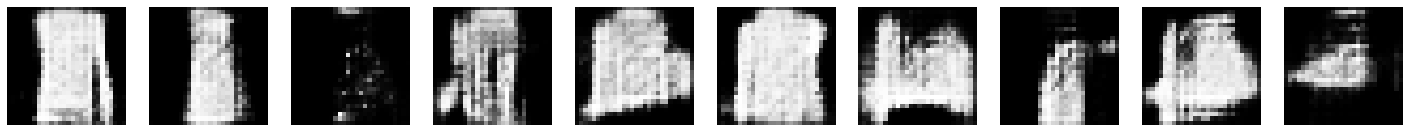

... finished after 33.42 seconds 
Epoch: __ 12
Iteration #100 - Discriminator loss: -0.0355, Generator loss: -0.1444
Iteration #200 - Discriminator loss: -0.018, Generator loss: -0.0653
Iteration #300 - Discriminator loss: -0.0272, Generator loss: -0.042
Iteration #400 - Discriminator loss: -0.0254, Generator loss: 0.0215
Iteration #500 - Discriminator loss: -0.0227, Generator loss: 0.0138
Iteration #600 - Discriminator loss: -0.0039, Generator loss: -0.0596
Iteration #700 - Discriminator loss: 0.0034, Generator loss: -0.1111
Iteration #800 - Discriminator loss: -0.0303, Generator loss: -0.2737
Iteration #900 - Discriminator loss: -0.0101, Generator loss: -0.214


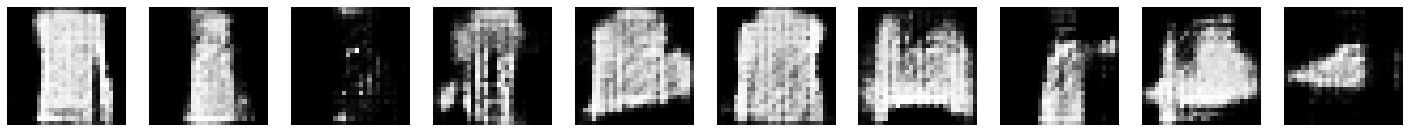

... finished after 33.5 seconds 
Epoch: __ 13
Iteration #100 - Discriminator loss: -0.0252, Generator loss: -0.0091
Iteration #200 - Discriminator loss: -0.0171, Generator loss: -0.0477
Iteration #300 - Discriminator loss: 0.0039, Generator loss: 0.0961
Iteration #400 - Discriminator loss: 0.0148, Generator loss: 0.1563
Iteration #500 - Discriminator loss: 0.0469, Generator loss: -0.4383
Iteration #600 - Discriminator loss: -0.0012, Generator loss: -0.0971
Iteration #700 - Discriminator loss: 0.0049, Generator loss: 0.0329
Iteration #800 - Discriminator loss: -0.0034, Generator loss: -0.1973
Iteration #900 - Discriminator loss: 0.0041, Generator loss: -0.123


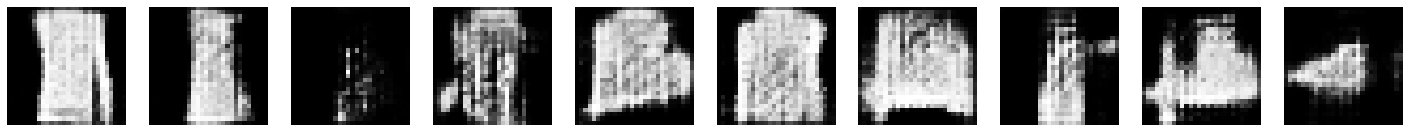

... finished after 33.31 seconds 
Epoch: __ 14
Iteration #100 - Discriminator loss: -0.0023, Generator loss: 0.0019
Iteration #200 - Discriminator loss: 0.0005, Generator loss: -0.2148
Iteration #300 - Discriminator loss: -0.0329, Generator loss: 0.1474
Iteration #400 - Discriminator loss: 0.0148, Generator loss: -0.2054
Iteration #500 - Discriminator loss: 0.03, Generator loss: 0.0592
Iteration #600 - Discriminator loss: -0.0226, Generator loss: 0.0781
Iteration #700 - Discriminator loss: -0.0196, Generator loss: 0.108
Iteration #800 - Discriminator loss: -0.0282, Generator loss: -0.0506
Iteration #900 - Discriminator loss: -0.0191, Generator loss: -0.0876


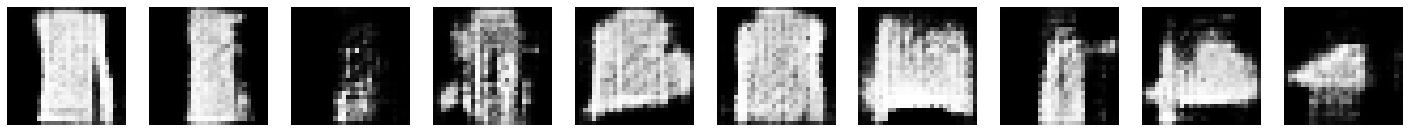

... finished after 33.07 seconds 
Epoch: __ 15
Iteration #100 - Discriminator loss: -0.0449, Generator loss: -0.2269
Iteration #200 - Discriminator loss: -0.058, Generator loss: -0.1717
Iteration #300 - Discriminator loss: -0.012, Generator loss: -0.419
Iteration #400 - Discriminator loss: 0.022, Generator loss: 0.1399
Iteration #500 - Discriminator loss: -0.0182, Generator loss: -0.0782
Iteration #600 - Discriminator loss: -0.0243, Generator loss: -0.0554
Iteration #700 - Discriminator loss: 0.0211, Generator loss: -0.2711
Iteration #800 - Discriminator loss: -0.0134, Generator loss: -0.1141
Iteration #900 - Discriminator loss: -0.0192, Generator loss: -0.0914


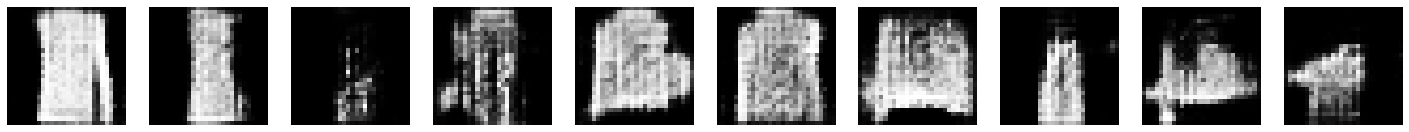

... finished after 33.18 seconds 
Epoch: __ 16
Iteration #100 - Discriminator loss: -0.0231, Generator loss: -0.1618
Iteration #200 - Discriminator loss: -0.0234, Generator loss: -0.1597
Iteration #300 - Discriminator loss: -0.0397, Generator loss: -0.1622
Iteration #400 - Discriminator loss: -0.0301, Generator loss: 0.0197
Iteration #500 - Discriminator loss: -0.028, Generator loss: -0.4439
Iteration #600 - Discriminator loss: 0.0005, Generator loss: -0.2598
Iteration #700 - Discriminator loss: 0.0004, Generator loss: -0.2261
Iteration #800 - Discriminator loss: 0.0452, Generator loss: 0.1423
Iteration #900 - Discriminator loss: -0.0182, Generator loss: -0.0446


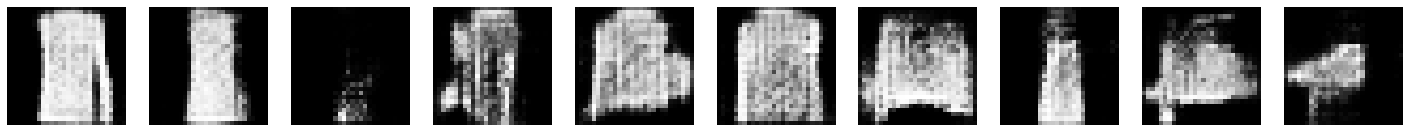

... finished after 33.01 seconds 
Epoch: __ 17
Iteration #100 - Discriminator loss: -0.0214, Generator loss: -0.1863
Iteration #200 - Discriminator loss: -0.0325, Generator loss: -0.2506
Iteration #300 - Discriminator loss: -0.0154, Generator loss: -0.0863
Iteration #400 - Discriminator loss: -0.0301, Generator loss: 0.1071
Iteration #500 - Discriminator loss: -0.0124, Generator loss: 0.0337
Iteration #600 - Discriminator loss: -0.022, Generator loss: -0.0287
Iteration #700 - Discriminator loss: 0.0302, Generator loss: 0.203
Iteration #800 - Discriminator loss: 0.0052, Generator loss: -0.1809
Iteration #900 - Discriminator loss: -0.0144, Generator loss: -0.0424


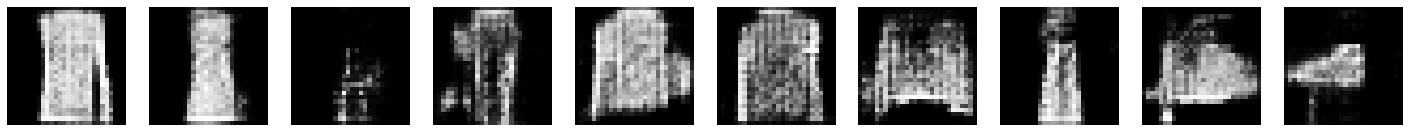

... finished after 32.38 seconds 
Epoch: __ 18
Iteration #100 - Discriminator loss: -0.0767, Generator loss: -0.3843
Iteration #200 - Discriminator loss: -0.0256, Generator loss: -0.1496
Iteration #300 - Discriminator loss: -0.0124, Generator loss: 0.0337
Iteration #400 - Discriminator loss: -0.05, Generator loss: -0.1649
Iteration #500 - Discriminator loss: -0.0229, Generator loss: 0.1015
Iteration #600 - Discriminator loss: -0.0169, Generator loss: -0.2044
Iteration #700 - Discriminator loss: -0.0077, Generator loss: -0.0682
Iteration #800 - Discriminator loss: -0.0129, Generator loss: 0.0915
Iteration #900 - Discriminator loss: -0.0187, Generator loss: -0.0941


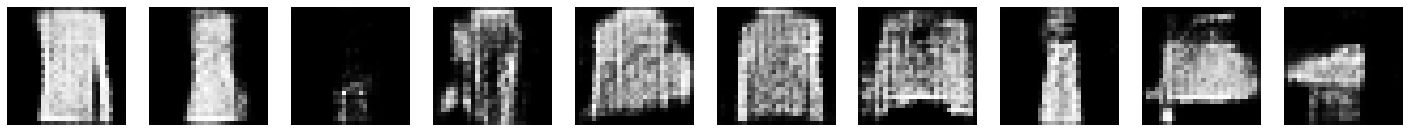

... finished after 32.25 seconds 
Epoch: __ 19
Iteration #100 - Discriminator loss: -0.0041, Generator loss: 0.1364
Iteration #200 - Discriminator loss: -0.0136, Generator loss: 0.0848
Iteration #300 - Discriminator loss: -0.0312, Generator loss: -0.0405
Iteration #400 - Discriminator loss: -0.0176, Generator loss: -0.1149
Iteration #500 - Discriminator loss: -0.0169, Generator loss: -0.393
Iteration #600 - Discriminator loss: -0.0141, Generator loss: -0.0918
Iteration #700 - Discriminator loss: -0.0472, Generator loss: -0.283
Iteration #800 - Discriminator loss: 0.027, Generator loss: -0.0195
Iteration #900 - Discriminator loss: 0.0006, Generator loss: -0.0385


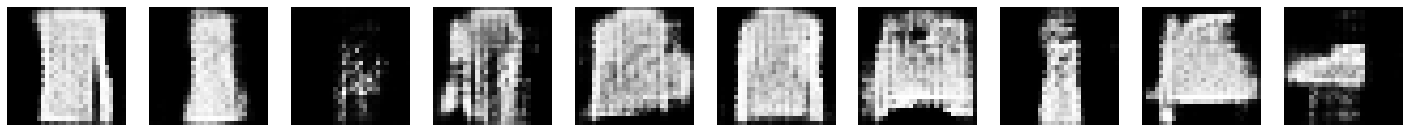

... finished after 32.63 seconds 
Epoch: __ 20
Iteration #100 - Discriminator loss: -0.0259, Generator loss: -0.008
Iteration #200 - Discriminator loss: -0.0881, Generator loss: 0.1804
Iteration #300 - Discriminator loss: 0.0105, Generator loss: -0.5133
Iteration #400 - Discriminator loss: 0.0496, Generator loss: 0.0685
Iteration #500 - Discriminator loss: 0.0354, Generator loss: -0.3486
Iteration #600 - Discriminator loss: -0.0158, Generator loss: -0.0541
Iteration #700 - Discriminator loss: -0.0251, Generator loss: -0.0338
Iteration #800 - Discriminator loss: -0.0279, Generator loss: -0.0364
Iteration #900 - Discriminator loss: -0.0154, Generator loss: -0.3098


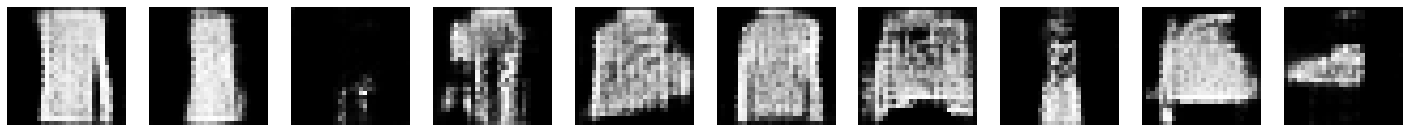

... finished after 33.18 seconds 


In [47]:
w_train_losses_d, w_test_losses_d, w_train_losses_g, w_test_losses_g, w_train_losses_g_all, w_train_losses_d_all = train(
    num_epochs=num_epochs, 
    generator=generator, 
    discriminator=discriminator, 
    g_loss=w_generator_loss, # Wasserstein loss adaption
    d_loss=w_discriminator_loss, # Wasserstein loss adaption
    optimizer_generator=optimizer_generator, 
    optimizer_discriminator=optimizer_discriminator)

**Evaluation of WGAN**

Using WGAN adjustments, we are able to construct images that look something like clothing. Some generated images are more distinguishable, others less  - but overall, the Wasserstein adjustments allowed for better results compared to the 'normal' GAN.

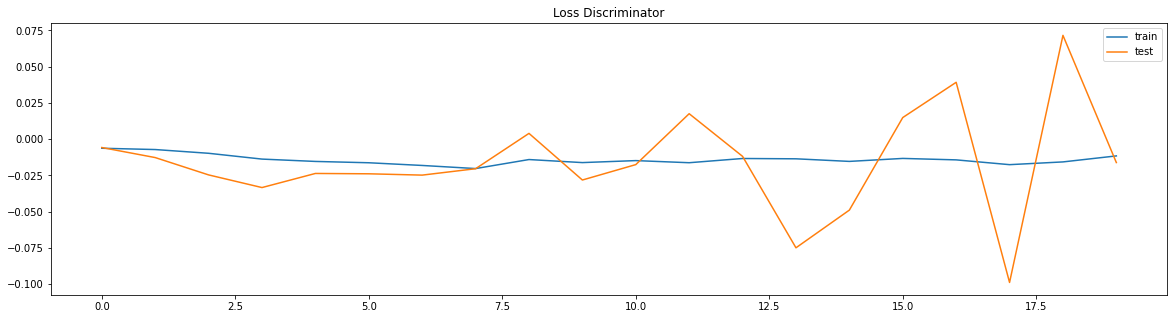

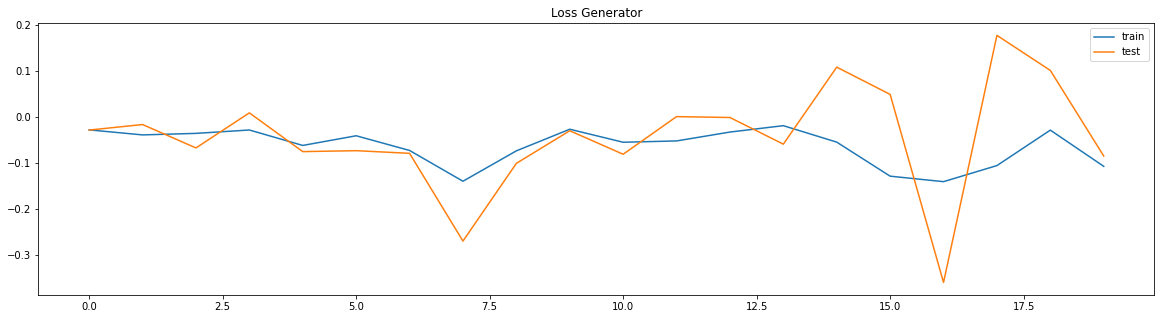

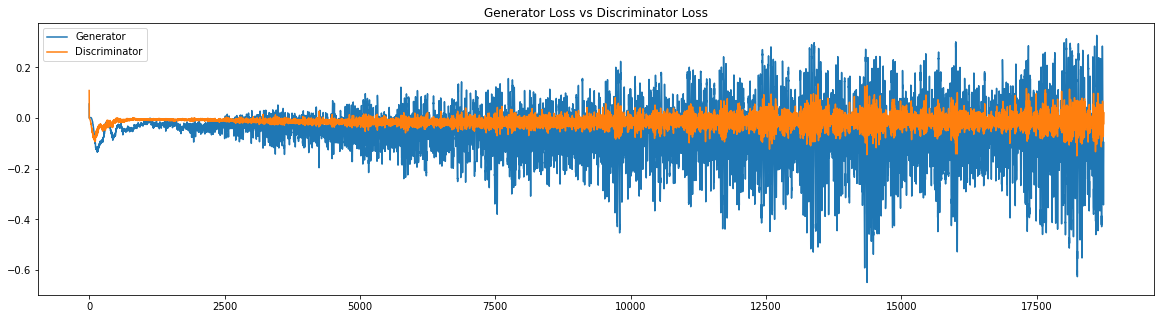

In [48]:
plot(w_train_losses_d, w_test_losses_d, w_train_losses_g, w_test_losses_g, w_train_losses_g_all, w_train_losses_d_all)